# Analyse de sensibilité globale avec les indices de Sobol'

**Application au cas de la déviation verticale d'une poutre encastrée.**

## Références
- http://openturns.github.io/openturns/master/user_manual/_generated/openturns.SaltelliSensitivityAlgorithm.html
- http://openturns.github.io/openturns/master/user_manual/_generated/openturns.SobolIndicesAlgorithm.html

## Déviation verticale d'une poutre encastrée

On considère le modèle de [poutre encastrée](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/0-Deroulement/Poutre-encastree.md).

## Quantité d'intérêt

Nous souhaitons estimer les indices de Sobol' du premier ordre et totaux. Nous pouvons le faire, car les variables aléatoires en entrée du modèle physique sont indépendantes.

L'indice de Sobol' du premier ordre est :

$$
S_i = \frac{\operatorname{Var}(\mathbb{E}[Y|X_i])}{\operatorname{Var}(Y)}
$$

pour $1 \leq i \leq d$ où $Y = g(\boldsymbol{X})$ et $\boldsymbol{X}$ est le vecteur aléatoire en entrée du modèle physique $g$.

L'indice de Sobol' total est :

$$
S_i^T = 1 - \frac{\operatorname{Var}(\mathbb{E}[Y|\boldsymbol{X}_{-i}])}{\operatorname{Var}(Y)}
$$

pour $1 \leq i \leq d$ où $\boldsymbol{X}_{-i} = (X_1, \ldots, X_{i-1}, X_{i+1}, \ldots, X_d)$ est un vecteur aléatoire en dimension $d - 1$.


In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np
import tabulate

## Définition du modèle

In [2]:
class Plongeoir:
    """
    Définit le modèle physique et probabiliste d'un plongeoir.

    Cette classe encapsule la définition des variables aléatoires d'entrée
    (module de Young, charge, longueur, moment d'inertie) et la fonction
    modèle calculant la déviation verticale de la poutre.

    Examples
    --------
    >>> plongeoir = Plongeoir()
    >>> inputDistributionPlongeoir = plongeoir.getProbabilisticModel()
    >>> physicalModelPlongeoir = plongeoir.getPhysicalModel()
    """

    def __init__(self):
        """
        Initialise les distributions et le modèle symbolique.
        """
        distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
        distributionE.setDescription(["E (Pa)"])
        parametersF = ot.LogNormalMuSigma(
            300.0, 30.0, 0.0
        )  # Paramétrage par les moments
        distributionF = ot.ParametrizedDistribution(parametersF)
        distributionF.setDescription(["F (N)"])
        distributionL = ot.Uniform(2.50, 2.60)  # En mètres
        distributionL.setDescription(["L (m)"])
        distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # En m⁴
        distributionI.setDescription(["I (m⁴)"])

        self.distribution = ot.JointDistribution(
            [distributionE, distributionF, distributionL, distributionI]
        )

        self.model = ot.SymbolicFunction(
            ["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"]
        )
        self.model.setInputDescription(self.distribution.getDescription())
        self.model.setOutputDescription(["Y (m)"])

    def getProbabilisticModel(self):
        """
        Retourne la distribution conjointe des variables d'entrée.

        Returns
        -------
        distribution : ot.JointDistribution
            La distribution conjointe des variables aléatoires d'entrée.
        """
        return self.distribution

    def getPhysicalModel(self):
        """
        Retourne le modèle physique sous forme de fonction symbolique.

        Returns
        -------
        model : ot.SymbolicFunction
            La fonction calculant la déviation verticale.
        """
        return self.model

In [3]:
plongeoir = Plongeoir()
inputDistributionPlongeoir = plongeoir.getProbabilisticModel()
physicalModelPlongeoir = plongeoir.getPhysicalModel()

## Estimer les indices de Sobol' avec un budget fixé

Le composant d'estimation des indices de Sobol' est équipé d'un système qui permet d'évaluer la fonction en dehors d'OpenTURNS. Pour l'utiliser, on crée un type de plan d'expériences spécial en utilisant la classe `SobolIndicesExperiment`. La méthode `generate` permet de créer le plan d'expériences associé à une taille fixée par l'utilisateur. 

In [4]:
size = 500
computeSecondOrder = False
sie = ot.SobolIndicesExperiment(inputDistributionPlongeoir, size, computeSecondOrder)
inputDesign = sie.generate()

La taille `size` est la taille du plan Monte-Carlo de base, utilisé pour obtenir un estimateur. Or plusieurs estimations sont requises dans ce cas particulier :

- Les moments d'ordre 1 et 2 de la sortie $Y$, c'est-à-dire l'espérance $\mathbb{E}[Y]$ et la variance $\operatorname{Var}(Y)$.
- Les indices de sensibilité pour chacune des quatre variables d'entrée ($E, F, L, I$), incluant les indices du premier ordre ($S_i$) et les indices totaux ($T_i$).

Pour estimer ces quantités, la méthode « _pick-freeze_ » requiert :

* un plan d'expériences de type "A",
* un plan d'expériences de type "B",
* des plans d'expériences de type "E" dont le nombre est égal à la dimension du vecteur d'entrée.

Il y a donc ici 4 plans d'expériences de type "E".

C'est pour cette raison que la taille du plan d'expériences permettant d'estimer toutes les quantités requises est égale à (1+1+4) * 500 = 3000.

In [5]:
inputDesign.getSize()

3000

In [6]:
outputDesign = physicalModelPlongeoir(inputDesign)

La bibliothèque dispose de quatre estimateurs des indices de Sobol'. Ici, nous proposons d'utiliser l'estimateur de Saltelli. 

In [7]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

On souhaite obtenir la distribution asymptotique.

In [8]:
sensitivityAnalysis.setUseAsymptoticDistribution(True)

Les méthodes `getFirstOrderIndices` et `getTotalOrderIndices` permettent de récupérer les indices du premier ordre et totaux.

In [9]:
firstOrderIndices = sensitivityAnalysis.getFirstOrderIndices()
print(f"Indices de Sobol' du premier ordre : {firstOrderIndices}")
totalOrderIndices = sensitivityAnalysis.getTotalOrderIndices()
print(f"Indices de Sobol' totaux : {totalOrderIndices}")

Indices de Sobol' du premier ordre : [0.0133299,0.625963,0.0336597,0.131095]
Indices de Sobol' totaux : [0.0506109,0.720178,0.101141,0.16765]


La méthode `draw` propose une méthode de dessin des indices de Sobol' qui permet d'observer à la fois les indices du premier ordre, les indices totaux et les intervalles de confiance.

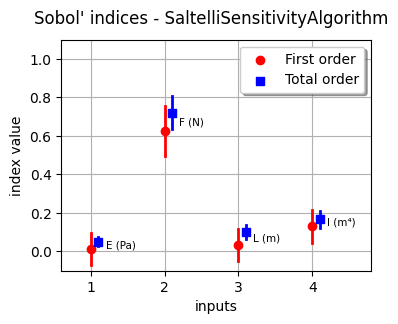

In [10]:
graph = sensitivityAnalysis.draw()
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Considérons en particulier la variable F. On observe que l'estimation de l'indice de sensibilité du premier ordre est légèrement supérieure à l'estimation de l'indice total. On sait que les valeurs exactes sont toujours de telle sorte que l'indice total est supérieur ou égal à l'indice du premier ordre. C'est donc à cause de l'erreur d'estimation que l'on obtient un ordre inverse. C'est la marque que 

- la taille de l'échantillon n'est pas suffisamment grande,
- ou l'indice du premier ordre est égal à l'indice total car il n'y a pas d'interaction.

Dans ce cas particulier, on observe que l'intervalle de confiance à 95% indique que l'estimation de l'indice du premier ordre de F est particulièrement large, approximativement entre 0.6 et 1.1. Dans ce cas particulier, il est pertinent d'augmenter la taille de l'échantillon.

La méthode `DrawSobolIndices` permet de réaliser un graphique similaire lorsque les indices sont déjà disponibles.

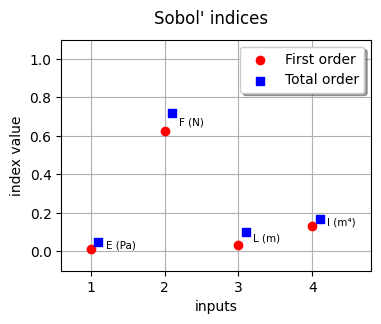

In [11]:
inputDescription = inputDistributionPlongeoir.getDescription()
graph = ot.SaltelliSensitivityAlgorithm.DrawSobolIndices(
    inputDescription, firstOrderIndices, totalOrderIndices
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

La méthode `getFirstOrderIndicesDistribution` retourne la distribution des indices de Sobol'. Elle peut être de deux types différents.

- Par défaut, la distribution des indices de Sobol' est estimée par ré-échantillonnage avec remise (nommé « _bootstrap_ » en anglais). Dans ce cas, la valeur de retour de `getFirstOrderIndicesDistribution` est de type `KernelMixture`, c'est-à-dire fondée sur une méthode d'estimation par lissage à noyau.
- Si on utilise la méthode `setUseAsymptoticDistribution`, alors on peut obtenir la distribution asymptotique fondée sur la méthode delta. Dans ce cas, la valeur de retour de `getFirstOrderIndicesDistribution` est de type `Normal`.

In [12]:
firstOrderDistribution = sensitivityAnalysis.getFirstOrderIndicesDistribution()
firstOrderDistribution

class=Normal name=Normal dimension=4 mean=class=Point name=Unnamed dimension=4 values=[0.0133299,0.625963,0.0336597,0.131095] sigma=class=Point name=Unnamed dimension=4 values=[0.0433529,0.0669184,0.0431375,0.0442043] correlationMatrix=class=CorrelationMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1]

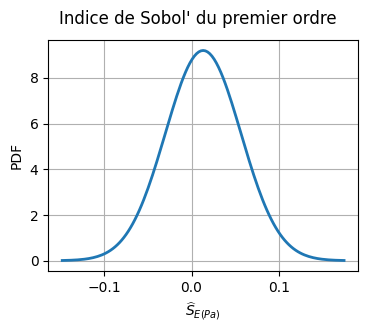

In [13]:
index = 0
foDistributionE = firstOrderDistribution.getMarginal(index)
graph = foDistributionE.drawPDF()
graph.setXTitle(r"$\widehat{S}_{" + inputDescription[index] + "}$")
graph.setTitle("Indice de Sobol' du premier ordre")
graph.setLegends([""])
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Estimer les indices de Sobol' avec un algorithme itératif

La classe `SobolSimulationAlgorithm` permet d'estimer les indices de Sobol' à l'aide d'un algorithme itératif. L'objectif principal de cette classe est de pouvoir configurer la précision d'estimation de l'indice de Sobol' à l'aide d'un intervalle de confiance dont le niveau de confiance `alpha` et la largeur `epsilon` sont fixés par l'utilisateur. Ainsi, les simulations sont réalisées par bloc, ce qui garantit à la fois une performance maximale sur les supercalculateurs et un nombre minimal de blocs évalués. Le paramètre `designSize` permet d'obtenir un estimateur asymptotique. Le paramètre `blockSize` permet d'obtenir une évaluation parallélisée du modèle physique `g`. Cette dernière fonctionnalité n'a d'intérêt que si la fonction permet d'évaluer plusieurs points simultanément. Cela peut être implémenté avec la classe `PythonFunction` et l'option `func_sample`, par exemple.

In [14]:
alpha = 0.05  # Pour un intervalle de confiance à 95%
epsilon = 0.2  # Longueur de l'intervalle de confiance
blockSize = 64  # Nombre de points évalués simultanément
designSize = 200  # Taille du plan d'expérience à chaque itération
maximumOuterSampling = 1200  # Nombre d'itérations externes de l'algorithme

estimator = ot.SaltelliSensitivityAlgorithm()
estimator.setUseAsymptoticDistribution(True)
algo = ot.SobolSimulationAlgorithm(inputDistributionPlongeoir, physicalModelPlongeoir, estimator)
algo.setMaximumOuterSampling(maximumOuterSampling)
algo.setBlockSize(blockSize)
algo.setExperimentSize(designSize)
algo.setIndexQuantileLevel(alpha)
algo.setIndexQuantileEpsilon(epsilon)
algo.run()

result = algo.getResult()
firstOrderIndices = result.getFirstOrderIndicesEstimate()
totalOrderIndices = result.getTotalOrderIndicesEstimate()
print(f"Indice de Sobol' du premier ordre = {firstOrderIndices}")
print(f"Indice de Sobol' total = {totalOrderIndices}")

Indice de Sobol' du premier ordre = [0.0320096,0.635104,0.0833577,0.147527]
Indice de Sobol' total = [0.0319215,0.749702,0.0878819,0.148159]


In [15]:
outerSampling = result.getOuterSampling()
print(f"outerSampling = {outerSampling}")
if outerSampling == maximumOuterSampling:
    print("Attention : le nombre maximum d'itérations externes est atteint !")

numberOfFunctionEvaluations = outerSampling * blockSize
print(f"Nombre d'évaluations de la fonction : {numberOfFunctionEvaluations}")

outerSampling = 6
Nombre d'évaluations de la fonction : 384


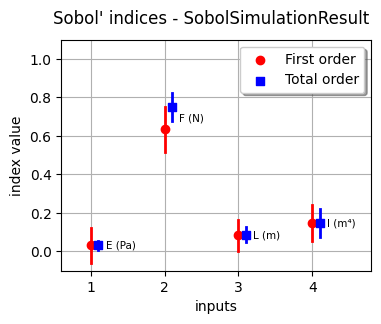

In [16]:
graph = result.draw()
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

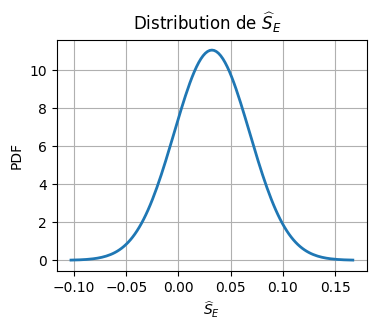

In [17]:
dist_fo = result.getFirstOrderIndicesDistribution()
dist_fo_i = dist_fo.getMarginal(0)
graph = dist_fo_i.drawPDF()
graph.setTitle(r"Distribution de $\widehat{S}_E$")
graph.setXTitle(r"$\widehat{S}_E$")
graph.setLegends([""])
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

In [18]:
data = []
inputDescription = physicalModelPlongeoir.getInputDescription()
#
alpha = 0.95
dimension = physicalModelPlongeoir.getInputDimension()
distributionFirstOrder = result.getFirstOrderIndicesDistribution()
distributionTotal = result.getTotalOrderIndicesDistribution()
for i in range(dimension):
    # Premier ordre
    marginal_first_order = distributionFirstOrder.getMarginal(i)
    interval = marginal_first_order.computeBilateralConfidenceInterval(alpha)
    lowerFirstOrder = interval.getLowerBound()[0]
    upperFirstOrder = interval.getUpperBound()[0]
    # Total
    marginal_total = distributionTotal.getMarginal(i)
    interval = marginal_total.computeBilateralConfidenceInterval(alpha)
    lowerTotal = interval.getLowerBound()[0]
    upperTotal = interval.getUpperBound()[0]
    #
    data.append(
        [
            f"{inputDescription[i]}",
            f"[{lowerFirstOrder:.2f}, {upperFirstOrder:.2f}]",
            f"[{lowerTotal:.2f}, {upperTotal:.2f}]",
        ]
    )

#
print("Table 1. Estimation des indices de Sobol'.")
tabulate.tabulate(
    data,
    tablefmt="html",
    headers=[
        "Variable",
        f"Premier ordre, I.C. {alpha*100.0}%",
        f"Total, I.C. {alpha*100.0}%",
    ],
)

Table 1. Estimation des indices de Sobol'.


Variable,"Premier ordre, I.C. 95.0%","Total, I.C. 95.0%"
E (Pa),"[-0.04, 0.10]","[0.01, 0.05]"
F (N),"[0.54, 0.73]","[0.69, 0.81]"
L (m),"[0.02, 0.15]","[0.06, 0.12]"
I (m⁴),"[0.07, 0.22]","[0.09, 0.20]"


## Analyse des indices de Sobol'

Voici les conclusions que l'on peut tirer.

- La variable $F$ est la variable qui contribue le plus à la variabilité de la sortie, à hauteur de 70 à 90%.
- La variable $I$ est la seconde variable qui contribue le plus à la variabilité de la sortie, à hauteur de 10 à 20%.
- Les deux autres variables $E$ et $L$ contribuent à moins de 10% de la variabilité de la sortie : elles pourraient être remplacées par des constantes (surtout la variable $E$), sans que la variabilité de la sortie $Y$ ne soit beaucoup modifiée.
- Sur la base des calculs, on peut indiquer que les interactions, si elles existent, ne contribuent pas beaucoup à la variabilité de la sortie. 

**Remarque.** Les indices de Sobol' sont compris entre 0 et 1. Toutefois, une estimation d'un indice de Sobol' peut être négative ou supérieure à 1. Cela est dû à la taille finie de l'échantillon, ce qui implique une certaine variabilité de l'estimateur. De même, l'indice de Sobol' du premier ordre est inférieur ou égal à l'indice de Sobol' total. Pour la même raison que précédemment, pour une variable $X_i$, l'estimation de l'indice total peut être inférieure à l'estimation de l'indice du premier ordre.

## Liste des exercices

Voici la liste des exercices :

- Exercice 1 : fonction produit
- Exercice 2 : fonction Ishigami
- Exercice 3 : variabilité de l'estimateur
- Exercice 4 : estimation par échantillonnage
- Exercice 5 : utilisation d'une séquence de Sobol' pour estimer les indices de Sobol'

## Exercice 1 : fonction produit

On considère la fonction :
$$
g(X_1,X_2)=X_1 X_2
$$
pour tout $X_1,X_2\in\mathbb{R}$. 
On suppose que les variables sont indépendantes et suivent les lois suivantes.

| Variable | Distribution |
|--|--|
| $X_1$ | Normal($\mu=0$, $\sigma=10$) |
| $X_2$ | Uniforme($a=-1$, $b=1$) |

**Table 1.** Modèle probabiliste du modèle physique de produit.

La cellule suivante définit le modèle.

In [19]:
physicalModelProduit = ot.SymbolicFunction(["X1", "X2"], ["X1 * X2"])
X1 = ot.Normal(0.0, 10.0)
X2 = ot.Uniform(-1.0, 1.0)
inputDistributionProduit = ot.JointDistribution([X1, X2])
inputDistributionProduit.setDescription(["X1", "X2"])

**Questions.**

- Estimer les indices SRC carrés. Pour cela, utiliser la classe `CorrelationAnalysis().computeSquaredSRC()`. 
- Pour valider vos résultats, utiliser la fonction `CorrelationAnalysis.computeLinearCorrelation()` :

```python
ot.CorrelationAnalysis(sampleX, sampleY).computeLinearCorrelation()
```

Comparer vos résultats : qu'observez-vous ?

- Estimer les indices de Sobol' avec la classe `SaltelliSensitivityAlgorithm`. Qu'observez-vous ? Comment expliquer ce résultat ?

## Exercice 2 : fonction Ishigami

On considère la fonction 

$$
g(X_1,X_2,X_3) = \sin(X_1)+a \sin (X_2)^2 + b X_3^4 \sin(X_1)
$$

pour tout $X_1,X_2,X_3\in[-\pi,\pi]$ où $a=7$ et $b=0.1$. 
On suppose que les variables sont indépendantes et suivent la loi uniforme entre $-\pi$ et $\pi$.

La cellule suivante définit le modèle.

In [20]:
inputNames = ["X1", "X2", "X3"]
physicalModelIshigami = ot.SymbolicFunction(
    inputNames, ["sin(X1) + 7.0 * sin(X2)^2 + 0.1 * X3^4 * sin(X1)"]
)
inputDistributionIshigami = ot.JointDistribution([ot.Uniform(-np.pi, np.pi)] * 3)
inputDistributionIshigami.setDescription(inputNames)

**Questions.**

- Estimer les indices SRC carrés avec la classe `CorrelationAnalysis.computeSquaredSRC()`
- Estimer les indices SRC carrés avec la classe `CorrelationAnalysis.computeLinearCorrelation()`. 
- Estimer les indices de Sobol'. 
- Qu'observez-vous ?

## Exercice 3 : variabilité de l'estimateur

On considère le cas de la déviation verticale de la poutre encastrée. Avec une méthode Monte-Carlo et l'estimateur de Saltelli, on souhaite observer la variabilité de l'estimateur des indices du premier ordre. Pour cela, nous allons répéter l'estimation des indices du premier ordre $r$ fois, avec $r=100$. Dans chaque expérience, nous allons estimer les indices du premier ordre avec un plan d'expériences de taille $n$, avec $n=500$.

**Questions.**

- Créer la variable `r=100`. 
- Créer la variable `sampleS` contenant un `Sample` de taille `r` et de dimension 4. Cette variable est destinée à contenir l'échantillon des estimations des indices du premier ordre.
- Créer la variable `n=500`.
- Créer une boucle `for` de 0 à `r-1`. Pour chaque élément `j` de la boucle, estimer les indices du premier ordre et stocker le résultat dans `sampleS[j,:]`.
- Dessiner l'histogramme empirique de l'indice de Sobol' du premier ordre pour la variable $E$
- Dessiner la loi gaussienne asymptotique issue de la méthode `getFirstOrderIndicesDistribution`. Est-ce que les deux distributions sont comparables ?

## Exercice 4 : estimation par échantillonnage

On considère le cas de la déviation verticale de la poutre encastrée. On souhaite mettre en oeuvre la méthode fondée sur l'échantillonnage pour estimer les indices de sensibilité. Dans le contexte de la quantification des incertitudes, cette méthode est nommée « _pick-freeze_ » en anglais.

**Création des plans A, B, E**

On considère trois plans d'expériences générés par échantillonnage Monte-Carlo simple notés $A$ et $B$ de taille $n$ et de dimension $d$ où $d$ est la dimension du vecteur aléatoire. Plus précisément, on considère :

$$
A = 
\begin{pmatrix}
a_{1,1} & a_{1,2} & \cdots & a_{1,d} \\
a_{2,1} & a_{2,2} & \cdots & a_{2,d} \\
\vdots  & \vdots  &        & \vdots \\
a_{n,1} & a_{n,2} & \cdots & a_{n,d}
\end{pmatrix} \in \mathbb{R}^{n \times d}
, \qquad 
B=
\begin{pmatrix}
b_{1,1}  & b_{1,2}  & \cdots  & b_{1,d}  \\
b_{2,1}  & b_{2,2}  & \cdots  & b_{2,d}  \\
\vdots   & \vdots   &         & \vdots  \\
b_{n,1}  & b_{n,2}  & \cdots  & b_{n,d} 
\end{pmatrix}  \in \mathbb{R}^{n \times d}.
$$

Pour $i=1, \ldots,d$, on souhaite estimer l'indice du premier ordre $S_i$ et l'indice 
total $S_i^T$. Pour cela on crée les plans $E$ sur la base des deux plans 
d'expériences $A$ et $B$. Le plan $E$ est créé à partir de $A$, dans lequel la $i$-ème 
colonne est celle de $B$. Plus précisément :
$$
E=
\begin{pmatrix}
a_{1,1}  & a_{1,2}  & \cdots  & b_{1,i} & \cdots  & a_{1,d}  \\
a_{2,1}  & a_{2,2}  & \cdots  & b_{2,i} & \cdots  & a_{2,d}  \\
\vdots   & \vdots   &         & \vdots  &         & \vdots  \\
a_{n,1}  & a_{n,2}  & \cdots  & b_{n,i} & \cdots  & a_{n,d} 
\end{pmatrix}  \in \mathbb{R}^{n \times d}.
$$

**Plans A, B et E**

Soient $\boldsymbol{y}^{A} \in \mathbb{R}^n$, $\boldsymbol{y}^{B} \in \mathbb{R}^n$ et $\boldsymbol{y}^{E} \in \mathbb{R}^n$ le vecteur des sorties du modèle $g$ sur les plans $A$, $B$ et $E$ :
$$
\boldsymbol{y}^{(A)} = g(\textbf{A}), \qquad 
\boldsymbol{y}^{(B)} = g(\textbf{B}), \qquad 
\boldsymbol{y}^{(E)} = g(\textbf{E}).
$$

**Estimateur de Martinez**

L'estimateur de Martinez est :
$$
\widehat{S}_i = \widehat{\rho}_n\left(\boldsymbol{y}^{(B)},\boldsymbol{y}^{(E)}\right), \qquad 
\widehat{S}_i^T = 1 - \widehat{\rho}_n\left(\boldsymbol{y}^{(A)}, \boldsymbol{y}^{(E)}\right)
$$

où $\widehat{\rho}_n$ est le coefficient de corrélation de Pearson.



**Centrage de la fonction**

Soient $\overline{y}^A$, $\overline{y}^B$ et $\overline{y}^E$ la moyenne empirique des 
sorties des plans $A$ et $B$ :
$$
\overline{y}^A = \frac{1}{n} \sum_{j=1}^n y^{(A,j)}, \qquad
\overline{y}^B = \frac{1}{n} \sum_{j=1}^n y^{(B,j)}.
$$

Soit $\alpha$ la moyenne empirique des sorties sur les échantillons $A$ et $B$ :
$$
\alpha = \frac{1}{2} \left(\overline{y}^A + \overline{y}^B\right).
$$
Soient $\boldsymbol{z}^{(A)}$, $\boldsymbol{z}^{(B)}$ et $\boldsymbol{z}^{(E)}$ le vecteur des sorties centrées du modèle $g$ sur les plans $A$, $B$ et $E$ :
$$
\boldsymbol{z}^{(A)} = \boldsymbol{y}^{A} - \alpha, \qquad 
\boldsymbol{z}^{(B)} = \boldsymbol{y}^{B} - \alpha, \qquad 
\boldsymbol{z}^{(E)} = \boldsymbol{y}^{E} - \alpha.
$$



**Estimateur de Saltelli**

L'estimateur est :
$$
\widehat{S}_i = \frac{\left\langle \boldsymbol{z}^{(B)}, \boldsymbol{z}^{(E)} \right\rangle}{\left\| \boldsymbol{z}^{(B)} \right\|_2^2} \qquad 
\widehat{T}_i = 1 - \frac{\left\langle \boldsymbol{z}^{(A)}, \boldsymbol{z}^{(E)} \right\rangle}{\left\|\boldsymbol{z}^{(A)}\right\|_2^2}.
$$
pour $i=1, \ldots, d$ où $\left\langle \boldsymbol{u}, \boldsymbol{v} \right\rangle$ est le produit scalaire des vecteurs $\boldsymbol{u}$ et $\boldsymbol{v}$ de dimensions $n$ et $\|\boldsymbol{u}\|_2^2 = \langle \boldsymbol{u}, \boldsymbol{u}\rangle$ est le carré de la norme euclidienne du vecteur $\boldsymbol{u}$.

**Questions.**

- Créer le script permettant d'estimer les indices grâce à l'estimateur de Martinez. Pour cela, utiliser la méthode `CorrelationAnalysis.computeLinearCorrelation()`.  Utiliser une boucle `for` pour estimer les indices de Sobol' du premier ordre et les indices totaux. Estimer les indices de Sobol' du premier ordre et totaux.

Pour cela, nous suggérons d'utiliser le squelette de code suivant, où vous remplacerez des cellules de code `TODO` par du code valide.

**Estimateur de Martinez**

```python
sampleSize = TODO
XA = inputDistributionPlongeoir.getSample(sampleSize)
XB = inputDistributionPlongeoir.getSample(sampleSize)
YA = physicalModelPlongeoir(TODO)
YB = physicalModelPlongeoir(TODO)
dimension = inputDistributionPlongeoir.getDimension()
firstOrderMartinez = ot.Point(dimension)
totalOrderMartinez = ot.Point(dimension)
for i in range(dimension):
    XEi = ot.Sample(XA)  # Crée une copie
    XEi[TODO] = XB[TODO]
    TODO = physicalModelPlongeoir(TODO)
    firstOrderMartinez[i] = ot.CorrelationAnalysis(TODO).TODO
    totalOrderMartinez[i] = 1.0 - ot.CorrelationAnalysis(TODO).TODO
```

- En utilisant une méthode Monte-Carlo, développez le script fondé sur l'estimateur de Saltelli centré. On peut utiliser la fonction `sampleDotProduct()`, présentée ci-dessous, qui facilite le travail.

**Estimateur de Saltelli, partie 1**
```python
# Génère un premier plan d'expériences de taille n : A
sampleSize = 500
XA = inputDistributionPlongeoir.getSample(sampleSize)
YA = physicalModelPlongeoir(TODO)
# Génère un second plan : B
XB = inputDistributionPlongeoir.getSample(sampleSize)
YB = physicalModelPlongeoir(TODO)
# Centre les échantillons de sortie (en place).
center = 0.5 * (YA.TODO + YB.TODO)
YA -= TODO
YB -= TODO
```

**Estimateur de Saltelli, partie 2**

```python
dimension = inputDistributionPlongeoir.getDimension()
firstOrderSaltelli = ot.Point(dimension)  # Indice du premier ordre
totalOrderSaltelli = ot.Point(dimension)  # Indice total
norm2YA = sampleDotProduct(TODO)
norm2YB = sampleDotProduct(TODO)
for i in range(dimension):
    XEi = ot.Sample(XA)  # Crée une copie
    XEi[TODO] = XB[TODO]  # Substitue la i-ème colonne
    YEi = physicalModelPlongeoir(TODO) - TODO  # Évalue le plan E centré
    firstOrderSaltelli[i] = sampleDotProduct(TODO) / TODO
    totalOrderSaltelli[i] = 1.0 - sampleDotProduct(TODO) / TODO
```

- Comparez les résultats produits par les deux méthodes : qu'observez-vous ?

Pour faciliter votre travail, vous pourrez utiliser la fonction `computeDotProduct()` ci-dessous. Elle permet de transformer deux échantillons unidimensionnels de taille $n$ en vecteurs et retourne le produit scalaire de ces deux vecteurs.

In [21]:
def sampleDotProduct(sampleA, sampleB):
    """
    Computes the dot product of two 1D-samples.

    Parameters
    ----------
    sampleA : ot.Sample(size, 1)
        A sample.
    sampleB : ot.Sample(size, 1)
        A sample.

    Returns
    -------
    y : float
        The dot product of sampleA and sampleB.

    """
    sampleAPoint = sampleA.asPoint()
    sampleBPoint = sampleB.asPoint()
    y = sampleAPoint.dot(sampleBPoint)
    return y

## Exercice 5 : utilisation d'une séquence de Sobol' pour estimer les indices de Sobol'

Utiliser un plan d'expériences de type séquence à faible discrépance pour estimer les indices de sensibilité. Pour cela, on utilisera la séquence de Sobol'. 

**Questions.**
- Pour clarifier l'algorithme, on définira la fonction `martinezSobolIndices` qui utilisera l'estimateur de Martinez pour estimer les indices de Sobol'. Sa séquence d'appel devra être :

```python
S, T = martinezSobolIndices(XA, XB)
```

- Utiliser cette fonction de telle sorte que `XA` et `XB` soient issus d'une séquence à faible discrépance de taille $n$ en dimension $2d$. 
- Puis, on découpera ce plan d'expériences en deux plans d'expériences de dimension $d$. La séquence de Sobol' peut être générée grâce aux classes `SobolSequence` et `LowDiscrepancyExperiment`.
